In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, "../src/")
sys.path.insert(0, "../projects/skimpy_bench/src/")
sys.path.insert(0, "../projects/skimpy_blox/")

In [2]:
import math
import functools
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path

import skimpy
import _skimpy_cpp_ext
import _skimpy_bench_cpp_ext
from skimpy import config as skimpy_config
from skimpy_bench import benchmarks
from skimpy_blox.minecraft import SkimpyMinecraftLevel

sns.set()

In [3]:
NUM_REPEATS = 1
BYTES_PER_INT = 4
MEGABYTES = 1024 * 1024
colors = sns.color_palette()

def log_2_elements_space(start_size, end_size, num):
    return np.logspace(math.log2(start_size), math.log2(end_size), base=2, num=num).astype(int)

def color_for_key(key):
    key = key.lower()
    if key.startswith("memory"):
        return colors[0]
    elif key.startswith("numpy"):
        return colors[1]
    elif key.startswith("torch"):
        return colors[2]
    elif key.startswith("taco"):
        return colors[3]
    elif key.startswith("pyskip"):
        return colors[4]
    else:
        offset = 5
        return colors[offset + hash(key) % (len(colors) - offset)]


def line_plot(
    xs,
    ys_dict,
    xlabel=None,
    ylabel=None,
    title=None,
    output_path=None,
    xlog=True,
    ylog=True,
    ylim=None,
):
    fig, ax = plt.subplots(figsize=(8, 6))
    
    for legend_name, v_dict in ys_dict.items():
        if legend_name == "extra":
            continue
        ax.plot(xs, v_dict["vals"], label=legend_name, linewidth=2) #, color=color_for_key(legend_name))
        
    if title:
        plt.title(title)
    if ylabel:
        plt.ylabel(ylabel)
    if xlabel:
        plt.xlabel(xlabel)
    if xlog:
        plt.xscale("log")
    if ylog:
        plt.yscale("log")
    if ylim is not None:
        plt.ylim(ylim)
    ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: f"{x:.1f}" if x < 1 else f"{x:.0f}"))
    #ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    plt.legend()
    
    if output_path:
        plt.tight_layout()
        plt.savefig(output_path, dpi=300)
    plt.show()
    
    
def plot_bar(vals, title=None, xlabel=None, xlog=True, output_path=None, normed_labels=True, xticks=None):
    fig, ax = plt.subplots(figsize=(8, 6))
    
    vals = {k: v for k, v in vals.items() if k != "extra"}
    min_val = min(e["val"] for e in vals.values())
    

    for i, (legend_name, v_dict) in enumerate(sorted(vals.items(), key=lambda x: x[1]['val'], reverse=True)):
    
        val = v_dict["val"]
        ax.barh(legend_name, val, color=color_for_key(legend_name))
        if val / min_val < 10:
            ax.text(val + 5, i - 0.1, f"{val / min_val:.1f}x", color='black')    
        else:
            ax.text(val + 5, i - 0.1, f"{val / min_val:.0f}x", color='black')

    if title:
        plt.title(title)
    if xlabel:
        plt.xlabel(xlabel)
    if xlog:
        plt.xscale("log")
        
    
    
    plt.xlim(left=0)
    if xticks is not None:
        plt.xticks(xticks)
    # plt.xticks([0,1,10,100,1000,])
        
    # ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: f"{x:.1f}" if x < 1 else f"{x:.0f}"))
    #ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

    if output_path:
        plt.tight_layout()
        plt.savefig(output_path, dpi=300)
    plt.show()

FULL_SUITE = {
    "PySkip (t=1)": {
        "method": "run_skimpy",
        "kwargs": {
            "num_threads": 1
        },
    },
    "PySkip (t=32)": {
        "method": "run_skimpy",
        "kwargs": {
            "num_threads": 32
        },
    },
    "Taco (dense)": {
        "method": "run_taco",
    },
    "Torch (cpu, dense)": {
        "method": "run_torch",
        "kwargs": {
            "num_threads": 32,
        }
    },
    "Numpy": {
        "method": "run_numpy"
    },
    "Memory": {
        "method": "run_memory",
    },
}

FULL_SUITE_WITH_CUSTOM_ADD = {
    "PySkip (t=1, fixed kernel)": {
        "method": "run_skimpy",
        "kwargs": {
            "num_threads": 1,
            "use_custom_kernel": True,
        },   
    },
    "PySkip (t=32, fixed kernel)": {
        "method": "run_skimpy",
        "kwargs": {
            "num_threads": 32,
            "use_custom_kernel": True,
        },   
    },
    **FULL_SUITE,
}

SPARSE_SUITE = {
    "PySkip (t=1)": {
        "method": "run_skimpy",
        "kwargs": {
            "num_threads": 1
        },
    },
    "PySkip (t=1, fixed kernel)": {
        "method": "run_skimpy",
        "kwargs": {
            "num_threads": 1,
            "use_custom_kernel": True,
        },   
    },
    "PySkip (t=32)": {
        "method": "run_skimpy",
        "kwargs": {
            "num_threads": 32
        },
    },
    "PySkip (t=32, fixed kernel)": {
        "method": "run_skimpy",
        "kwargs": {
            "num_threads": 32,
            "use_custom_kernel": True,
        },   
    },
    "Torch (cpu, sparse)": {
        "method": "run_torch",
        "kwargs": {
            "dense": False,
            "num_threads": 32,
        }
    },
    "Torch (cpu, dense)": {
        "method": "run_torch",
        "kwargs": {
            "dense": True,
            "num_threads": 32,
        }
    },
    "Taco (sparse)": {
        "method": "run_taco",
    },
    "Numpy (dense)": {
        "method": "run_numpy"
    },
    "Memory": {
        "method": "run_memory",
    },   
}
SPARSE_SUITE_NO_TACO = {k: v for k, v in SPARSE_SUITE.items() if k != "Taco"}

CONV_SUITE_WITH_GPU = {
    "PySkip (t=1)": {
        "method": "run_skimpy",
        "kwargs": {
            "num_threads": 1
        },
    },
    "PySkip (t=32)": {
        "method": "run_skimpy",
        "kwargs": {
            "num_threads": 32
        },
    }, 
    "Scipy (numpy)": {
        "method": "run_numpy",
    },
    "Torch (cpu, dense)": {
        "method": "run_torch",
        "kwargs": {
            "num_threads": 32,    
        },
    },
    "Torch (gpu, dense)": {
        "method": "run_torch",
        "kwargs": {
            "device": "cuda:0",
            "num_threads": 32,    
        }
    },
}
CONV_SUITE_NO_GPU = {k: v for k, v in CONV_SUITE_WITH_GPU.items() if k != "Torch (gpu)"}

THREAD_SUITE = {
    "PySkip (t=32)": {
        "method": "run_skimpy",
        "kwargs": {
            "num_threads": 32
        },
    },
    "PySkip (t=32, fixed kernel)": {
        "method": "run_skimpy",
        "kwargs": {
            "num_threads": 32,
            "use_custom_kernel": True,
        },   
    },
    "PySkip (t=64)": {
        "method": "run_skimpy",
        "kwargs": {
            "num_threads": 64
        },
    },
    "PySkip (t=64, fixed kernel)": {
        "method": "run_skimpy",
        "kwargs": {
            "num_threads": 64,
            "use_custom_kernel": True,
        },   
    },
    "PySkip (t=128)": {
        "method": "run_skimpy",
        "kwargs": {
            "num_threads": 128
        },
    },
    "PySkip (t=128, fixed kernel)": {
        "method": "run_skimpy",
        "kwargs": {
            "num_threads": 128,
            "use_custom_kernel": True,
        },   
    },
}

In [4]:
def dense_suite(num_inputs, array_lengths):
    return benchmarks.DenseArrayBenchmark.run_suite_axis(
        'array_length', array_lengths,
        repeats=NUM_REPEATS,
        num_inputs=num_inputs,
        suite=FULL_SUITE_WITH_CUSTOM_ADD,
    )

In [5]:
array_lengths = log_2_elements_space(256 // BYTES_PER_INT, 256 * MEGABYTES // BYTES_PER_INT, num=2)
four_way = dense_suite(num_inputs=4, array_lengths=array_lengths,)
sixteen_way = dense_suite(num_inputs=16, array_lengths=array_lengths,)

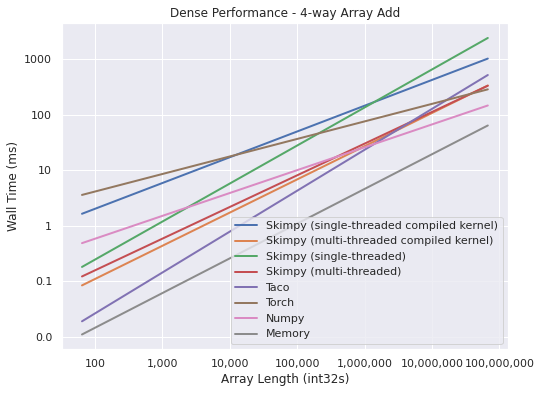

In [6]:
line_plot(
    array_lengths, 
    four_way, 
    xlabel="Array Length (int32s)", 
    ylabel="Wall Time (ms)",
    title="Dense Performance - 4-way Array Add",
)

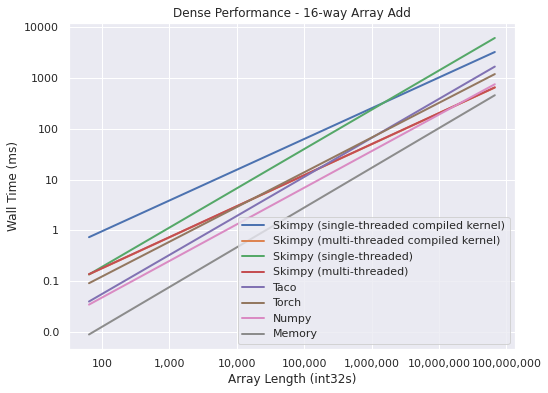

In [8]:
line_plot(
    array_lengths, 
    sixteen_way, 
    xlabel="Array Length (int32s)", 
    ylabel="Wall Time (ms)",
    title="Dense Performance - 16-way Array Add",
)

In [4]:
dense_six_way = benchmarks.DenseArrayBenchmark.run_suite(
    array_length=128_000_000,
    repeats=3,
    num_inputs=6,
    suite=FULL_SUITE_WITH_CUSTOM_ADD,
)

26
26
26


/home/tdimson/anaconda3/envs/skimpy/lib/python3.7/site-packages/ipykernel_launcher.py:87: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


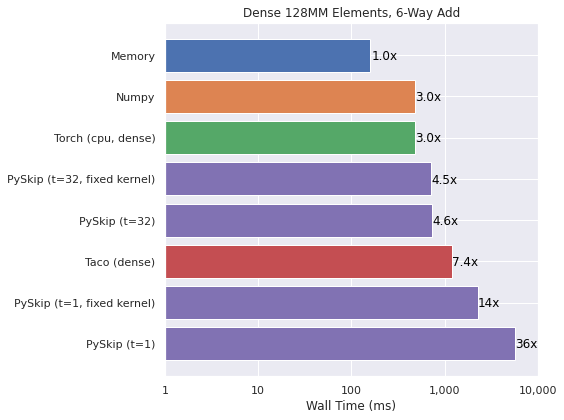

In [5]:
plot_bar(dense_six_way, 
         title="Dense 128MM Elements, 6-Way Add", 
         xlabel="Wall Time (ms)", xlog=True,
         xticks=np.array([1, 10, 100, 1000, 10000]),
         output_path="/home/tdimson/projects/cs348k/project/final_report/plots/dense_6_way_add.png")

In [54]:
threads = np.array([1, 2, 4, 8, 16, 32])
dense_six_way = benchmarks.DenseArrayBenchmark.run_suite_axis(
    'override_skimpy_threads', threads,
    array_length=128_000_000,
    repeats=3,
    num_inputs=6,
    suite={
        "PySkip": { 
            "method": "run_skimpy",
            "kwargs": {
                "use_accelerated": True,
            }
        },
        "PySkip (naive traversal)": { 
            "method": "run_skimpy",
        },
        "PySkip (fixed kernel, naive traversal)": { 
            "method": "run_skimpy",
            "kwargs": {
                "use_custom_kernel": True
            }
        },
        "PySkip (fixed kernel, naive traversal)": { 
            "method": "run_skimpy",
            "kwargs": {
                "use_custom_kernel": True,
                "use_accelerated": True,
            }
        },
    }
)

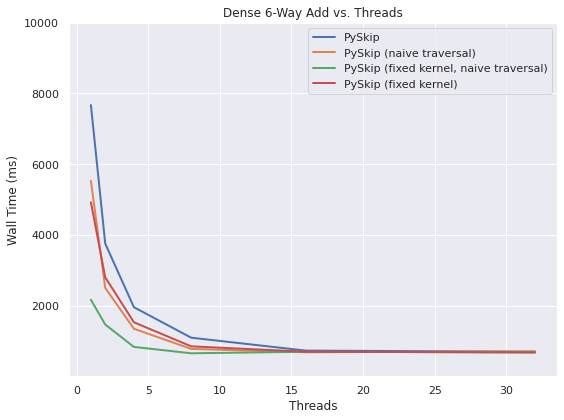

In [56]:
line_plot(
    threads, 
    dense_six_way, 
    xlabel="Threads", 
    ylabel="Wall Time (ms)",
    title="Dense 6-Way Add vs. Threads",
    xlog=False,
    ylog=False,
    output_path="/home/tdimson/projects/cs348k/project/final_report/plots/dense_6_way_add_threads.png",
    ylim=(1,10000),
)

In [36]:
dense_six_way

{'PySkip': {'vals': array([5691.144835  , 2506.861567  , 1343.731516  ,  785.68746233,
          702.75880567,  691.370403  ])},
 'PySkip (fixed kernel)': {'vals': array([2167.795751  , 1452.85655433,  811.05869367,  642.03428767,
          646.054726  ,  666.39768367])},
 'PySkip (fixed kernel, tournament)': {'vals': array([5096.605168  , 2829.45629133, 1512.30264833,  867.72532733,
          675.79087267,  691.23824833])}}

/home/tdimson/anaconda3/envs/skimpy/lib/python3.7/site-packages/ipykernel_launcher.py:84: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


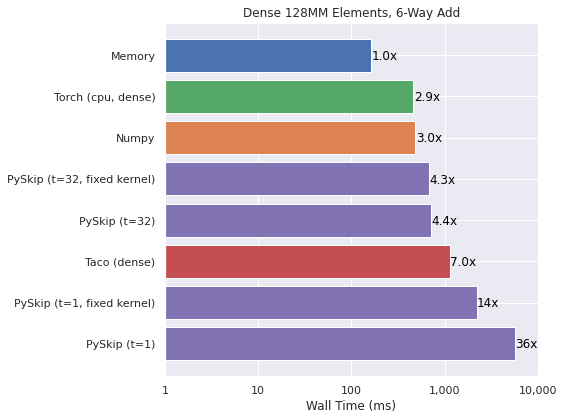

In [ ]:
plot_bar(gigabyte_array_4, title="Dense 512MB Arrays, 4-Way Add", xlabel="Wall Time (ms)", xlog=True, 
         output_path="/home/tdimson/projects/cs348k/project/final_report/plots/dense_4_way_add.png")

In [ ]:
plot_bar(gigabyte_array_4, title="Dense 512MB Arrays, 16-Way Add", xlabel="Wall Time (ms)", xlog=True, 
         output_path="/home/tdimson/projects/cs348k/project/final_report/plots/dense_4_way_add.png")

In [13]:
def dense_suite_num_inputs(num_inputs, array_length):
    return benchmarks.DenseArrayBenchmark.run_suite_axis(
        'num_inputs', num_inputs,
        repeats=NUM_REPEATS,
        suite=FULL_SUITE,
        array_length=array_length,
    )

In [15]:
num_inputs = np.arange(1, 32)
array_length_vals = dense_suite_num_inputs(num_inputs=num_inputs, array_length=(10*MEGABYTES // BYTES_PER_INT))

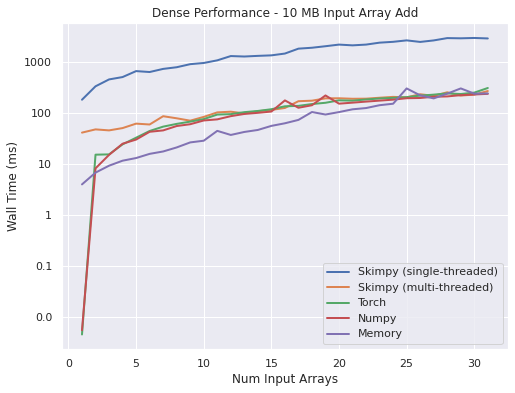

In [23]:
line_plot(
    num_inputs, 
    array_length_vals, 
    xlabel="Num Input Arrays", 
    ylabel="Wall Time (ms)",
    title="Dense Performance - 10 MB Input Array Add",
    xlog=False,
)

# Purely Sparse Benchmark Performance
This represents some number of non-zero elements per array.

Notes:
- Numpy represents dense
- Taco compile grows exponentially in number of sources (hence limiting to 8)
- Taco JIT compile time is not included, but can be significant

In [4]:
def pure_sparse_suite(num_non_zeros, num_inputs, suite=SPARSE_SUITE):
    return benchmarks.RunLengthArrayBenchmark.run_suite_axis(
        'num_non_zero', num_non_zeros,
        repeats=NUM_REPEATS,
        array_length=256 * MEGABYTES,
        num_inputs=num_inputs,
        align_inputs=False,
        deterministic_run_length=True,
        run_length=1,
        suite=suite,
    )

In [5]:
num_non_zeros = log_2_elements_space(256, 10_000_000, num=2)
four_way_sparse = pure_sparse_suite(num_non_zeros, num_inputs=4)
eight_way_sparse = pure_sparse_suite(num_non_zeros, num_inputs=8, suite=SPARSE_SUITE_NO_TACO)

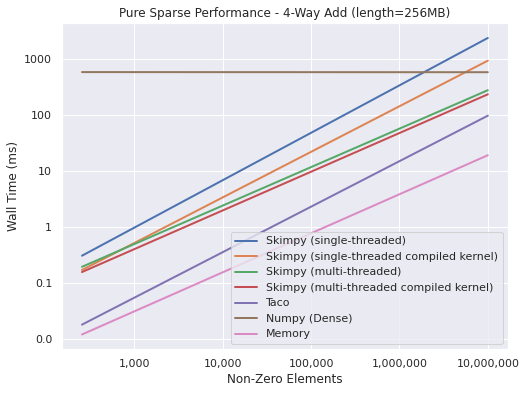

In [6]:
line_plot(
    num_non_zeros, 
    four_way_sparse, 
    xlabel="Non-Zero Elements", 
    ylabel="Wall Time (ms)",
    title="Pure Sparse Performance - 4-Way Add (length=256MB)",
)

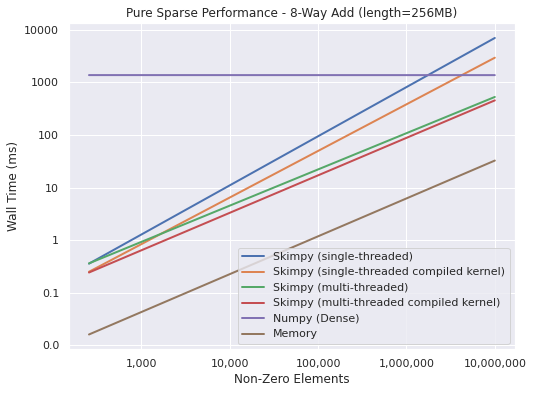

In [7]:
line_plot(
    num_non_zeros, 
    eight_way_sparse, 
    xlabel="Non-Zero Elements", 
    ylabel="Wall Time (ms)",
    title="Pure Sparse Performance - 8-Way Add (length=256MB)",
)

In [ ]:
b = benchmarks.RunLengthArrayBenchmark(
    num_non_zero=int(128_000_000 * 0.01 / 1),
    array_length=128_000_000 // 1, 
    num_inputs=6,
    align_inputs=False,
    deterministic_run_length=True,
    run_length=1,
)
for i in range(1000):
    b.run_taco()
    print(i)

In [12]:
density_01_threads = benchmarks.RunLengthArrayBenchmark.run_suite(
    repeats=3,
    num_non_zero=int(128_000_000 * 0.01 / approximation),
    array_length=128_000_000 // approximation, 
    num_inputs=6,
    align_inputs=False,
    deterministic_run_length=True,
    run_length=1,
    suite=THREAD_SUITE,
)

In [4]:
approximation = 10
density_01 = benchmarks.RunLengthArrayBenchmark.run_suite(
    repeats=3,
    num_non_zero=int(128_000_000 * 0.01 / approximation),
    array_length=128_000_000 // approximation, 
    num_inputs=6,
    align_inputs=False,
    deterministic_run_length=True,
    run_length=1,
    suite=SPARSE_SUITE,
)

/opt/conda/conda-bld/pytorch_1587428266983/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


0
0
0


In [5]:
density_01

{'PySkip (t=1)': {'val': 65.32089366666666},
 'PySkip (t=1, fixed kernel)': {'val': 19.547882666666666},
 'PySkip (t=32)': {'val': 8.002468},
 'PySkip (t=32, fixed kernel)': {'val': 4.088447},
 'Torch (cpu, sparse)': {'val': 34.660482333333334},
 'Torch (cpu, dense)': {'val': 81.85238466666667},
 'Taco (sparse)': {'val': 2.5903333333333336},
 'Numpy (dense)': {'val': 48.423398999999996},
 'Memory': {'val': 0.4113333333333334},
 'extra': {'dense_bytes': 51200000.0,
  'sparse_bytes': 1018937.3333333334,
  'run_bytes': 2027756.0,
  'output_dense_bytes': 307200000,
  'output_sparse_bytes': 5964016,
  'output_run_bytes': 11579664}}

In [7]:
11579664 / 307200000.0

0.03769421875

In [6]:
density_10 = benchmarks.RunLengthArrayBenchmark.run_suite(
    repeats=3,
    num_non_zero=int(128_000_000 * 0.1 / approximation),
    array_length=128_000_000 // approximation,
    num_inputs=6,
    align_inputs=False,
    deterministic_run_length=True,
    run_length=1,
    suite=SPARSE_SUITE,
)

0
0
0


In [7]:
density_10

{'PySkip (t=1)': {'val': 458.28264999999993},
 'PySkip (t=1, fixed kernel)': {'val': 178.72173766666666},
 'PySkip (t=32)': {'val': 37.890644},
 'PySkip (t=32, fixed kernel)': {'val': 31.177362},
 'Torch (cpu, sparse)': {'val': 343.5359296666666},
 'Torch (cpu, dense)': {'val': 53.32003133333333},
 'Taco (sparse)': {'val': 12.061666666666667},
 'Numpy (dense)': {'val': 48.47753066666667},
 'Memory': {'val': 3.6246666666666667},
 'extra': {'dense_bytes': 51200000.0,
  'sparse_bytes': 9747198.666666666,
  'run_bytes': 18565330.666666668}}

/home/tdimson/anaconda3/envs/skimpy/lib/python3.7/site-packages/ipykernel_launcher.py:92: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


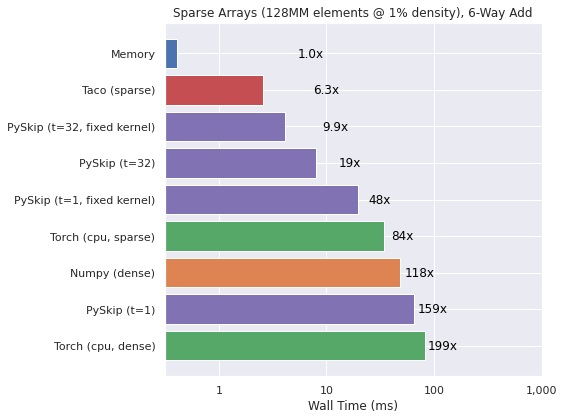

In [6]:
plot_bar(density_01, title="Sparse Arrays (128MM elements @ 1% density), 6-Way Add", xlabel="Wall Time (ms)", xlog=True, 
         output_path="/home/tdimson/projects/cs348k/project/final_report/plots/sparse_6_way_add_density_01.png",
         xticks=np.array([1, 10, 100, 1000]),
        )

/home/tdimson/anaconda3/envs/skimpy/lib/python3.7/site-packages/ipykernel_launcher.py:92: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


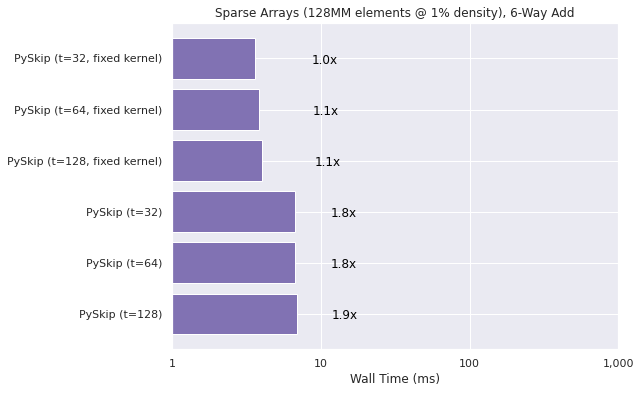

In [14]:
plot_bar(density_01_threads, title="Sparse Arrays (128MM elements @ 1% density), 6-Way Add", xlabel="Wall Time (ms)", xlog=True, 
         xticks=np.array([1, 10, 100, 1000]),
        )

/home/tdimson/anaconda3/envs/skimpy/lib/python3.7/site-packages/ipykernel_launcher.py:92: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


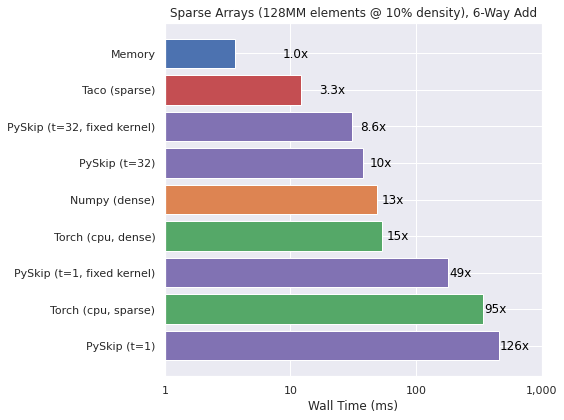

In [16]:
plot_bar(density_10, title="Sparse Arrays (128MM elements @ 10% density), 6-Way Add", xlabel="Wall Time (ms)", xlog=True, 
         output_path="/home/tdimson/projects/cs348k/project/final_report/plots/sparse_6_way_add_density_10.png",
         xticks=np.array([1, 10, 100, 1000]),
        )

# Run Length Benchmark Performance
This is a synthetic suite where we add together run-length encoded arrays. Each input contains N runs of length 100.

Notes:
- Numpy is represented in dense format
- Taco does not benefit from the run length encoding and represents things in sparse format
- Taco compile grows exponentially in number of sources (hence limiting to 8)
- Taco JIT compile time is not included, but can be significant

In [9]:
def heavy_runs_suite(num_non_zeros, num_inputs, suite=SPARSE_SUITE):
    return benchmarks.RunLengthArrayBenchmark.run_suite_axis(
        'num_non_zero', num_non_zeros,
        repeats=NUM_REPEATS,
        array_length=256 * MEGABYTES,
        num_inputs=num_inputs,
        align_inputs=False,
        deterministic_run_length=True,
        run_length=100,
        suite=suite,
    )

In [11]:
num_non_zeros = log_2_elements_space(256, 10_000_000, num=5)
four_way_heavy_runs = heavy_runs_suite(num_non_zeros, num_inputs=4)
eight_way_heavy_runs = heavy_runs_suite(num_non_zeros, num_inputs=8, suite=SPARSE_SUITE_NO_TACO)

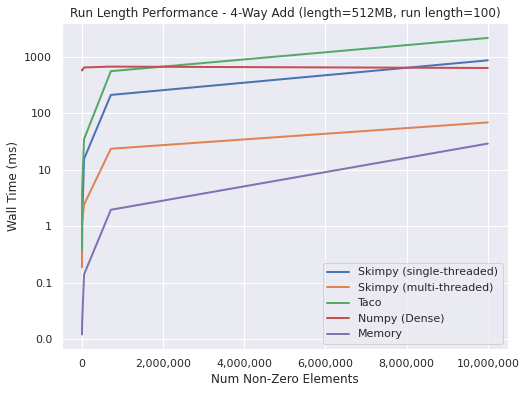

In [12]:
line_plot(
    num_non_zeros, 
    four_way_heavy_runs, 
    xlabel="Num 100-Length Runs", 
    ylabel="Wall Time (ms)",
    title="Run Length Performance - 4-Way Add (length=256MB)",
    xlog=False,
)

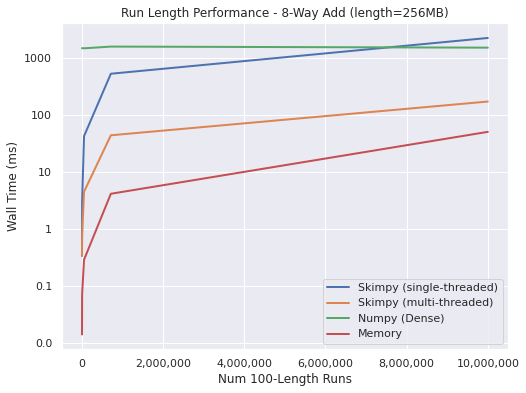

In [15]:
line_plot(
    num_non_zeros, 
    eight_way_heavy_runs, 
    xlabel="Num 100-Length Runs", 
    ylabel="Wall Time (ms)",
    title="Run Length Performance - 8-Way Add (length=256MB)",
    xlog=False,
)

In [4]:
run_length = 10
run_length_density_01 = benchmarks.RunLengthArrayBenchmark.run_suite(
    num_non_zero=int(128_000_000 * 0.01 / run_length),
    repeats=3,
    array_length=128_000_000,
    num_inputs=6,
    align_inputs=False,
    deterministic_run_length=True,
    run_length=run_length,
    suite=SPARSE_SUITE,
)

/opt/conda/conda-bld/pytorch_1587428266983/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


0
0
0


In [8]:
run_length_density_01

{'PySkip (t=1)': {'val': 68.76388466666667},
 'PySkip (t=1, fixed kernel)': {'val': 19.862813666666664},
 'PySkip (t=32)': {'val': 8.576986999999999},
 'PySkip (t=32, fixed kernel)': {'val': 4.47814},
 'Torch (cpu, sparse)': {'val': 338.41879566666665},
 'Torch (cpu, dense)': {'val': 577.9201286666666},
 'Taco (sparse)': {'val': 12.669333333333332},
 'Numpy (dense)': {'val': 489.4460106666666},
 'Memory': {'val': 0.3223333333333333},
 'extra': {'dense_bytes': 512000000.0,
  'sparse_bytes': 10190353.333333334,
  'run_bytes': 2037170.6666666667,
  'output_dense_bytes': 3072000000,
  'output_sparse_bytes': 59639576,
  'output_run_bytes': 12163048}}

In [11]:
12163048  / 59639576

0.20394256324022156

In [5]:
run_length_density_10 = benchmarks.RunLengthArrayBenchmark.run_suite(
    num_non_zero=int(128_000_000 * 0.1 / run_length),
    repeats=3,
    array_length=128_000_000,
    num_inputs=6,
    align_inputs=False,
    deterministic_run_length=True,
    run_length=run_length,
    suite=SPARSE_SUITE,
)

26455
26455
26455


In [9]:
run_length_density_10

{'PySkip (t=1)': {'val': 668.817999},
 'PySkip (t=1, fixed kernel)': {'val': 250.81569233333335},
 'PySkip (t=32)': {'val': 54.42603966666667},
 'PySkip (t=32, fixed kernel)': {'val': 45.94273966666666},
 'Torch (cpu, sparse)': {'val': 2488.0298166666666},
 'Torch (cpu, dense)': {'val': 589.3122146666666},
 'Taco (sparse)': {'val': 255.73733333333334},
 'Numpy (dense)': {'val': 474.8712373333333},
 'Memory': {'val': 3.7273333333333336},
 'extra': {'dense_bytes': 512000000.0,
  'sparse_bytes': 97486794.66666667,
  'run_bytes': 19400380.0,
  'output_dense_bytes': 3072000000,
  'output_sparse_bytes': 462928936,
  'output_run_bytes': 111179016}}

/home/tdimson/anaconda3/envs/skimpy/lib/python3.7/site-packages/ipykernel_launcher.py:92: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


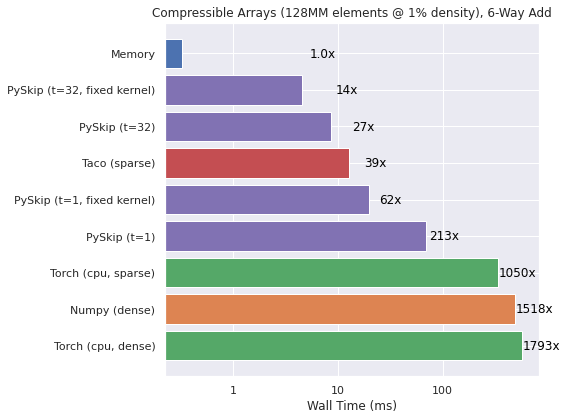

In [6]:
plot_bar(run_length_density_01, title="Compressible Arrays (128MM elements @ 1% density), 6-Way Add", xlabel="Wall Time (ms)", xlog=True, 
         output_path="/home/tdimson/projects/cs348k/project/final_report/plots/compressible_6_way_add_density_01.png")

/home/tdimson/anaconda3/envs/skimpy/lib/python3.7/site-packages/ipykernel_launcher.py:92: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


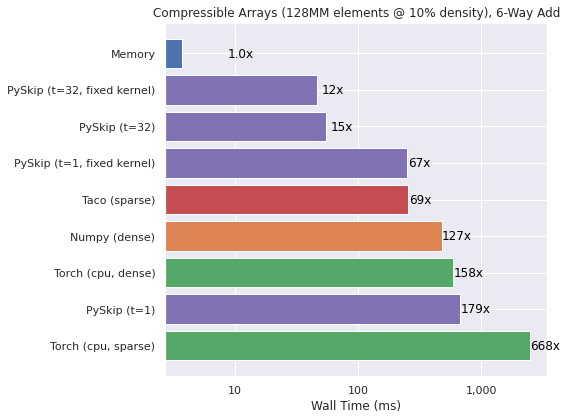

In [7]:
plot_bar(run_length_density_10, title="Compressible Arrays (128MM elements @ 10% density), 6-Way Add", xlabel="Wall Time (ms)", xlog=True, 
         output_path="/home/tdimson/projects/cs348k/project/final_report/plots/compressible_6_way_add_density_10.png")

# Convolution Performance
Notes:
- Torch is dense
- GPU time includes the output copy from GPU memory to CPU memory
- Torch uses multiple cores for computation on CPU

In [19]:
def dense_conv_suite(width, kernel_width):
    return benchmarks.Dense3DConvolutionBenchmark.run_suite_axis(
        'shape', [(e, e, e) for e in width],
        kernel_width=kernel_width,
        suite=CONV_SUITE_WITH_GPU,
        repeats=NUM_REPEATS,
    )

In [39]:
width = np.array([8, 16, 64, 128, 256, 512]).astype(int)
kernel_3_suite = dense_conv_suite(width, kernel_width=3)

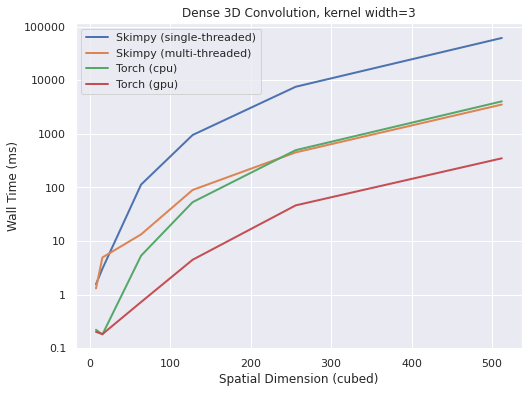

In [40]:
line_plot(
    width, 
    kernel_3_suite, 
    xlabel="Spatial Dimension (cubed)", 
    ylabel="Wall Time (ms)",
    title="Dense 3D Convolution, kernel width=3",
    xlog=False,
)

In [15]:
two_by_two = benchmarks.Dense3DConvolutionBenchmark.run_suite(
    shape=(256, 256, 256),
    kernel_width=3,
    suite=CONV_SUITE_WITH_GPU,
    repeats=3,
)

7
5
0


/home/tdimson/anaconda3/envs/skimpy/lib/python3.7/site-packages/ipykernel_launcher.py:92: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


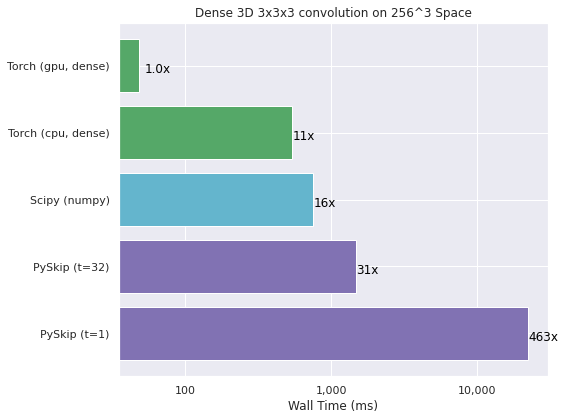

In [16]:
plot_bar(two_by_two, title="Dense 3D 3x3x3 convolution on 256^3 Space", xlabel="Wall Time (ms)", xlog=True,
         output_path="/home/tdimson/projects/cs348k/project/final_report/plots/dense_3d_conv.png")

In [18]:
run_length = 10
run_two_by_two = benchmarks.RunLength3DConvolutionBenchmark.run_suite(
    num_non_zero=int(0.1 * (256 ** 3) / (10 * run_length)), 
    run_length=10,
    align_inputs=False,
    deterministic_run_length=True,
    shape=(256, 256, 256),
    kernel_width=3,
    suite=CONV_SUITE_WITH_GPU,
    repeats=3,
)

0
0
0


/home/tdimson/anaconda3/envs/skimpy/lib/python3.7/site-packages/ipykernel_launcher.py:92: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


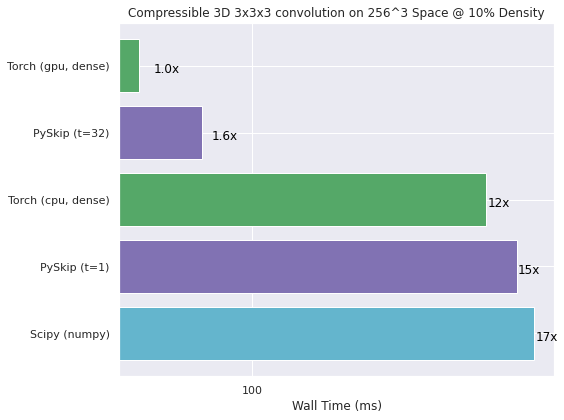

In [19]:
plot_bar(run_two_by_two, title="Compressible 3D 3^3 convolution on 256^3 Space @ 10% Density", xlabel="Wall Time (ms)", xlog=True,
         output_path="/home/tdimson/projects/cs348k/project/final_report/plots/compressible_3d_conv.png")

In [27]:
def run_length_conv_suite(num_non_zeros, spatial_width, kernel_width):
    return benchmarks.RunLength3DConvolutionBenchmark.run_suite_axis(
        'num_non_zero', num_non_zeros, 
        run_length=100,
        align_inputs=False,
        deterministic_run_length=True,
        shape=(spatial_width, spatial_width, spatial_width),
        kernel_width=kernel_width,
        suite=CONV_SUITE_WITH_GPU,
        repeats=NUM_REPEATS,
    )

In [18]:
num_non_zeros = log_2_elements_space(1000, 10_000_000, num=20)
kernel_run_length_suite = run_length_conv_suite(num_non_zeros, spatial_width=256, kernel_width=3)

KeyboardInterrupt: 

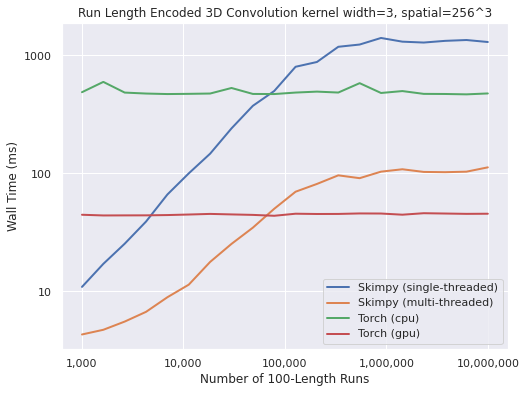

In [38]:
line_plot(
    num_non_zeros, 
    kernel_run_length_suite, 
    xlabel="Number of 100-Length Runs", 
    ylabel="Wall Time (ms)",
    title="Run Length Encoded 3D Convolution kernel width=3, spatial=256^3",
    xlog=True,
)

/home/tdimson/anaconda3/envs/skimpy/lib/python3.7/site-packages/ipykernel_launcher.py:79: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


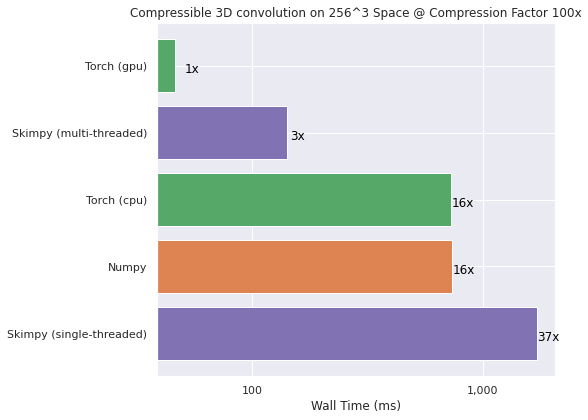

# MINECRAFT

In [8]:
level = SkimpyMinecraftLevel.load("/mnt/evo/projects/cs348k/Minecraft Levels - 2015/Pickled/Hogwarts1.0.pickle.gz")

In [14]:
minecraft_bench = benchmarks.MinecraftConvolutionBenchmark.run_suite(
    level=level, repeats=NUM_REPEATS, kernel_width=3, suite=CONV_SUITE_WITH_GPU,
)

/home/tdimson/anaconda3/envs/skimpy/lib/python3.7/site-packages/ipykernel_launcher.py:79: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


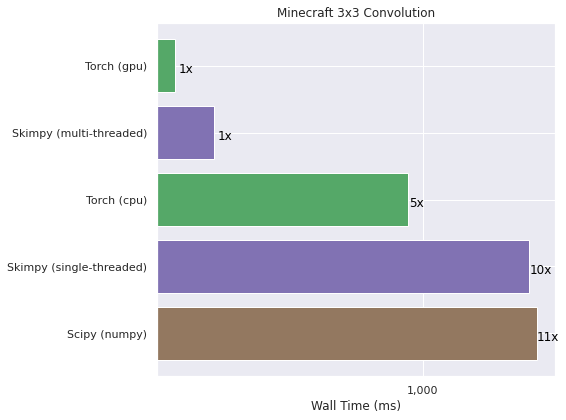

In [15]:
plot_bar(minecraft_bench, title="Minecraft 3x3 Convolution", xlabel="Wall Time (ms)", xlog=True,
         output_path="/home/tdimson/projects/cs348k/project/final_report/plots/minecraft_3d_conv_3x3.png")

# MNIST

In [21]:
mnist_bench = benchmarks.MNISTConvolutionBenchmark.run_suite(
    mnist_path="/home/tdimson/projects/skimpy/projects/skimpy_bench/data/mnist_train.csv.gz", 
    repeats=NUM_REPEATS, 
    kernel_width=3, 
    suite=CONV_SUITE_WITH_GPU,
    num_kernels=1,
)

/home/tdimson/anaconda3/envs/skimpy/lib/python3.7/site-packages/ipykernel_launcher.py:79: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


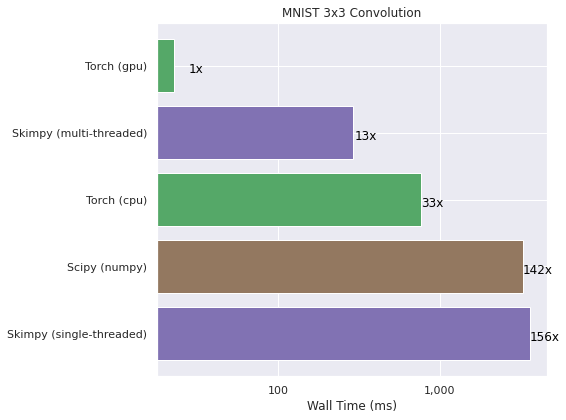

In [22]:
plot_bar(mnist_bench, title="MNIST 3x3 Convolution", xlabel="Wall Time (ms)", xlog=True,
         output_path="/home/tdimson/projects/cs348k/project/final_report/plots/mnist_2d_conv_3x3.png")

In [23]:
mnist_bench = benchmarks.MNISTConvolutionBenchmark.run_suite(
    mnist_path="/home/tdimson/projects/skimpy/projects/skimpy_bench/data/mnist_train.csv.gz", 
    repeats=NUM_REPEATS, 
    kernel_width=3, 
    suite=CONV_SUITE_WITH_GPU,
    num_kernels=1,
    quantize_buckets=2
)

/home/tdimson/anaconda3/envs/skimpy/lib/python3.7/site-packages/ipykernel_launcher.py:79: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


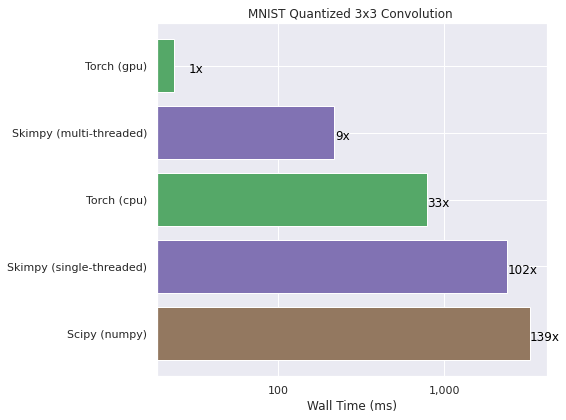

In [24]:
plot_bar(mnist_bench, title="MNIST Quantized 3x3 Convolution", xlabel="Wall Time (ms)", xlog=True,
         output_path="/home/tdimson/projects/cs348k/project/final_report/plots/mnist_2d_conv_3x3.png")